# Introduction

LSTMs are very powerful in sequence prediction problems because they’re able to store past information. This is important in our case because the previous price of a stock is crucial in predicting its future price.

We’ll kick of by importing NumPy for scientific computation, Matplotlib for plotting graphs, and Pandas to aide in loading and manipulating our datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Loading the Dataset

The next step is to load in our training dataset and select the Open and High columns that we’ll use in our modeling.

We check the head of our dataset to give us a glimpse into the kind of dataset we’re working with.

In [2]:
dataset_train = pd.read_csv('NSE-TATAGLOBAL.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [3]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


The Open column is the starting price while the Close column is the final price of a stock on a particular trading day. The High and Low columns represent the highest and lowest prices for a certain day.

## Feature Scaling

From previous experience with deep learning models, we know that we have to scale our data for optimal performance. In our case, we’ll use Scikit- Learn’s MinMaxScaler and scale our dataset to numbers between zero and one.

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

## Creating Data with Timesteps
**LSTMs** expect our data to be in a specific format, usually a *3D* array. We start by creating data in 60 timesteps and converting it into an array using `NumPy`. 

Next, we convert the data into a 3D dimension array with `X_train` samples, 60 timestamps, and one feature at each step.

In [6]:
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the LSTM
In order to build the LSTM, we need to import a couple of modules from Keras:
1. `Sequential` for initializing the neural network
2. `Dense` for adding a densely connected neural network layer
3. `LSTM` for adding the Long Short-Term Memory layer
4. `Dropout` for adding dropout layers that prevent overfitting

In [7]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

We add the `LSTM` layer and later add a few `Dropout` layers to prevent overfitting. We add the `LSTM` layer with the following arguments:

- 50 `units` which is the dimensionality of the output space
- `return_sequences=True` which determines whether to return the last output in the output sequence, or the full sequence
- `input_shape` as the shape of our training set.

When defining the `Dropout` layers, we specify 0.2, meaning that 20% of the layers will be dropped. Thereafter, we add the `Dense` layer that specifies the output of 1 unit. After this, we compile our model using the popular `Adam` optimizer and set the loss as the `mean_squarred_error`. This will compute the mean of the squared errors. Next, we fit the model to run on 100 epochs with a batch size of 32. Keep in mind that, depending on the specs of your computer, this might take a few minutes to finish running.

In [8]:
import numpy
numpy.version.version

'1.19.2'

In [9]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [10]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
62/62 [==============================] - 2s 38ms/step - loss: 0.0089
Epoch 2/100
62/62 [==============================] - 2s 38ms/step - loss: 0.0031
Epoch 3/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0029
Epoch 4/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0027
Epoch 5/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0024
Epoch 6/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0023
Epoch 7/100
62/62 [==============================] - 2s 40ms/step - loss: 0.0025
Epoch 8/100
62/62 [==============================] - 2s 38ms/step - loss: 0.0021
Epoch 9/100
62/62 [==============================] - 2s 38ms/step - loss: 0.0021
Epoch 10/100
62/62 [==============================] - 2s 38ms/step - loss: 0.0021
Epoch 11/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0018
Epoch 12/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0017
Epoch 13/100
62/62 [=====

## Predicting Future Stock using the Test Set
First we need to import the test set that we’ll use to make our predictions on.

In [12]:
dataset_test = pd.read_csv('tatatest.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In order to predict future stock prices we need to do a couple of things after loading in the test set:
1. Merge the training set and the test set on the 0 axis.
2. Set the time step as 60 (as seen previously)
3. Use `MinMaxScaler` to transform the new dataset
4. Reshape the dataset as done previously
After making the predictions we use `inverse_transform` to get back the stock prices in normal readable format.

In [13]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Plotting the Results
Finally, we use Matplotlib to visualize the result of the predicted stock price and the real stock price.

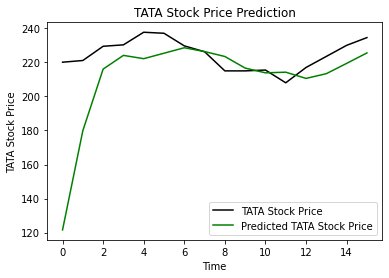

In [14]:
plt.plot(real_stock_price, color = 'black', label = 'TATA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

From the plot we can see that the real stock price went up while our model also predicted that the price of the stock will go up. This clearly shows how powerful LSTMs are for analyzing time series and sequential data.

# Conclusion
There are a couple of other techniques of predicting stock prices such as `moving averages`, `linear regression`, `K-Nearest Neighbours`, `ARIMA` and `Prophet`. These are techniques that one can test on their own and compare their performance with the `Keras LSTM`. If you wish to learn more about `Keras` and deep learning you can find my articles on that here and here.